In [56]:
from fastai.vision.all import *

In [54]:
path = Path("/home/nick/Documents/Work code/gimp_segmentation_plugin/sample data")
path_lbl = path/'mask'
path_img = path/'image'
model_output = path/'model output'

In [21]:
codes = np.loadtxt(path/'codes.txt', dtype=str)
codes

array(['Void', 'Road'], dtype='<U4')

In [24]:
img_size_for_model = 1000
batch_size = 2
model_type = resnet18

In [26]:
fnames = get_image_files(path_img)

In [27]:
def label_func(file_path): 
    file_name = os.path.basename(file_path)
    label_path = os.path.join(path_lbl,file_name)
    return label_path

In [28]:
item_tfms = [Resize(img_size_for_model)]
batch_tfms = [Normalize.from_stats(*imagenet_stats),
            *aug_transforms(size=img_size_for_model, flip_vert=True,max_rotate=90.0,max_lighting=0.1,max_warp=0),Normalize.from_stats(*imagenet_stats)]

In [29]:
dls = SegmentationDataLoaders.from_label_func(
    path, bs=batch_size, fnames = fnames, label_func = label_func, codes = codes,
    item_tfms=item_tfms,batch_tfms=batch_tfms
)

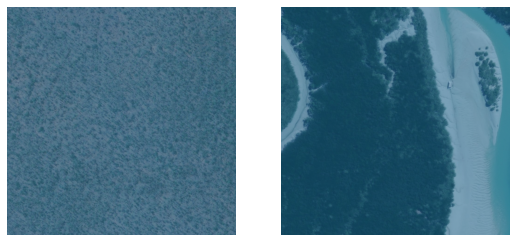

In [30]:
dls.show_batch(vmin=0, vmax=len(codes)-1, figsize=(9,12))

In [31]:
learn = unet_learner(dls, model_type).to_fp16()
model_name = 'road_model'

epoch,train_loss,valid_loss,time
0,12.680465,198.008484,00:19


Better model found at epoch 0 with valid_loss value: 198.00848388671875.


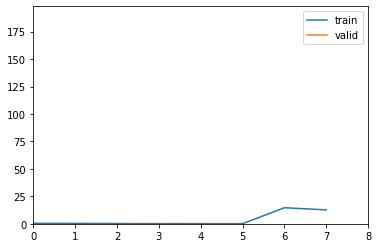

epoch,train_loss,valid_loss,time
0,142.511536,170.529434,00:08
1,120.808556,0.145058,00:07


Better model found at epoch 0 with valid_loss value: 170.52943420410156.


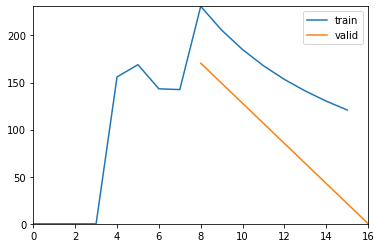

Better model found at epoch 1 with valid_loss value: 0.14505808055400848.


In [32]:
learn.fine_tune(2,cbs = [ShowGraphCallback(),SaveModelCallback(monitor='valid_loss',comp = np.less,with_opt=True, fname=model_name)])

In [33]:
# 800 10 13.6  dirty quick_model_800 
# 800 10 0.08 clean quick_model_1000.pkl

In [106]:
learn.load(model_name)

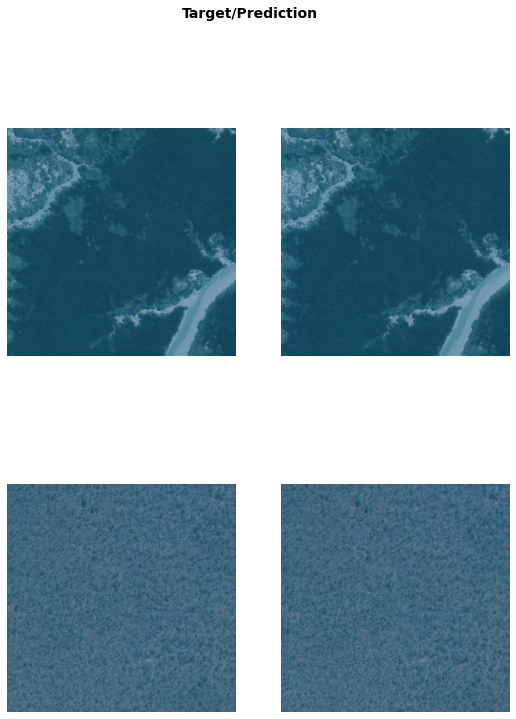

In [107]:
learn.show_results(max_n=6, figsize=(9,12),vmin=0, vmax=len(codes)-1)

In [108]:
# interp = SegmentationInterpretation.from_learner(learn)
# interp.plot_top_losses(k=3)

In [109]:
learn.load(model_name)
export_path = 'models/'+model_name+'.pkl'
print(export_path)
learn.export(export_path)

models/road_model.pkl


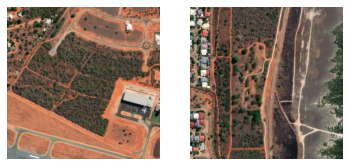

In [114]:
img_list = path_img.ls()
dl = learn.dls.test_dl(img_list,device='cuda',bs=batch_size)

dl.show_batch()

In [115]:
# dl = learn.dls.test_dl(chunk,device='cuda',bs=batch_size,)
preds = learn.get_preds(dl=dl,with_decoded=True)

In [116]:
import rasterio
preds = torch.mul(preds[0], 100)
preds_np = preds.numpy().astype('uint8')

In [118]:
for pred, img_path in zip(preds_np,img_list):
    file_name = os.path.basename(img_path)
    save_path = os.path.join(model_output,file_name)
    src = rasterio.open(img_path)
    meta_copy = src.meta
    src.closed
    meta_copy['count'] = len(codes)
    meta_copy['dtype'] = 'uint8'
    with rasterio.open(save_path, 'w', **meta_copy) as dst:
            dst.write(pred)